In [1]:
'''
pip install ipywidgets --upgrade
'''

'\npip install ipywidgets --upgrade\n'

In [2]:

# !pip install ipywidgets --upgrade
# !pip install -r /dccstor/fluidos/luba_dev/fluidos-model-orchestrator/requirements-dev.txt



In [3]:
import os
from pathlib import Path
# import sys
# base_path = Path(os.path.abspath("")).parent.parent
# sys.path.append(base_path.as_posix())
# base_path.as_posix()

In [4]:
# !pip install /dccstor/fluidos/luba_dev/fluidos-model-orchestrator/

In [5]:

import logging
import random
import shutil
from pathlib import Path
from typing import Any
import os

import numpy as np  # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf  # type: ignore
import torch  # type: ignore
import matplotlib.pyplot as plt

from fluidos_model_orchestrator.data_pipeline.augmentation.augmentation_utils import AUGMENTATION_TYPES
# class AUGMENTATION_TYPES:
#     PERFORMANCE_RATING = "performance_rating"
#     FEEDBACK_LOOP = "feedback_loop"
# from fluidos_model_orchestrator.data_pipeline.augmentation.augmentation_pipeline import create_augmented_dataset_df
# from fluidos_model_orchestrator.data_pipeline.data_processor_factory import DataProcessorFactory
from fluidos_model_orchestrator.data_pipeline.data_util import FLUIDOS_DATASETS
from fluidos_model_orchestrator.data_pipeline.data_util import get_target_column
from fluidos_model_orchestrator.data_pipeline.data_util import load_ml_ready_df
from fluidos_model_orchestrator.model.utils import MODEL_TYPES
from fluidos_model_orchestrator.model_pipeline.model_trainer_factory import ModelTrainerFactory
# from fluidos_model_orchestrator.util import get_default_output_dir_path
# from fluidos_model_orchestrator.util import reset_output_dir
from fluidos_model_orchestrator.model.utils import FLUIDOS_COL_NAMES

import ipywidgets as widgets
widgets.IntSlider()

tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

## Hyperparameters

In [11]:
ROOT_DIR = Path(os.getcwd()).parent.parent

platform = "ccc"
dataset_name = FLUIDOS_DATASETS.BITBRAINS  # FLUIDOS_DATASETS.GCT
model_type = MODEL_TYPES.CG  # MODEL_TYPES.FLUIDOS_RANKER
augmentation = AUGMENTATION_TYPES.FEEDBACK_LOOP  # AUGMENTATION_TYPES.PERFORMANCE_RATING

epochs = 5
load_from_generated = 0
test_mode = False
max_pod = 2000
tr_number = 50 # -1 for gct

path_output_model = "<INSERT_YOUR_PATH_HERE>"
path_output = "<INSERT_YOUR_PATH_HERE>"
# path_output_model = "/dccstor/fluidos/luba_dev/tid_bitbrains_100k/"
# path_output = "/dccstor/fluidos/luba_dev/tid_bitbrains_100k"
# path_output_model = "/Users/killianlevacher/Downloads/tmp_fluidos/tid_bitbrains_100k/"
# path_output = "/Users/killianlevacher/Downloads/tmp_fluidos/tid_bitbrains_100k"


dataset_subset = "rnd"
# path_dataset_ml_ready = None
# path_dataset_ml_ready = "/dccstor/fluidos/luba_dev/tid_bitbrains_100k/dataset/bitbrains_v0_train/ml_ready_augmented/feedback_loop"
# path_dataset_ml_ready = '/Users/killianlevacher/Downloads/tmp_fluidos/feedback_loop'
path_dataset_ml_ready = "<INSERT_YOUR_PATH_HERE>"

MODEL_SOURCE = "model_source"
FED_MODELS_TRAINED = [MODEL_SOURCE, "model_B", "model_C"]

In [13]:
def split_dataset(df: pd.DataFrame, model_names: list[str], model_source_name: str, train_ratio: float = 0.2, test_ratio: float = 0.05) -> dict[str, dict[str, Any]]:

    manifests = df[[FLUIDOS_COL_NAMES.POD_FILE_NAME, FLUIDOS_COL_NAMES.POD_MANIFEST]]
    counts = manifests[FLUIDOS_COL_NAMES.POD_MANIFEST].value_counts().to_dict()
    # Estimation of pod manifests distribution
    frequency_per_pod = []
    for index, row in manifests.iterrows():
        frequency_per_pod.append(counts[row[FLUIDOS_COL_NAMES.POD_MANIFEST]])

    manifests.insert(2, "frequency", frequency_per_pod)
    manifests = manifests.sort_values(by="frequency", ascending=False)
    manifests["frequency"] = manifests["frequency"] / len(manifests)
    manifests.index = range(len(manifests.index))
    manifests = manifests.reset_index()

    manifests_size = len(manifests)

    train_size = int(train_ratio * manifests_size)
    test_size = int(test_ratio * manifests_size) 
    test_manifests = manifests.sample(test_size)

    train_manifests = manifests[:train_size]
    local_manifests = manifests[train_size:]

    train_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(train_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    local_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(local_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    test_pods = df[df[FLUIDOS_COL_NAMES.POD_FILE_NAME].isin(test_manifests[FLUIDOS_COL_NAMES.POD_FILE_NAME])]
    split_size = len(local_pods) // (len(model_names) - 1)
    local_pods_chunks = [local_pods[i:i + split_size] for i in range(0, len(local_pods), split_size)]

    model_attributes = {}
    model_attributes[MODEL_SOURCE] = {"df_train": train_pods, "df_test": test_pods}
    for index, model_name in enumerate(model_names[1:]):
        model_attributes[model_name] = {"df_train": local_pods_chunks[index],
                                        "df_test": test_pods}
            
    return model_attributes

## Preparing Datasets

In [14]:

logging.info("Starting Model Building and Training")

ml_ready_dataset_path = Path(path_dataset_ml_ready)

pods_assigment_df, template_resources_df = load_ml_ready_df(ml_ready_dataset_path)

#TODO TMP - remove this when all tested 
pods_assigment_df = pods_assigment_df[:10000]

model_attributes = split_dataset(pods_assigment_df, FED_MODELS_TRAINED, MODEL_SOURCE)

Loading dataset: /Users/killianlevacher/Downloads/tmp_fluidos/feedback_loop


pods_assigment_df## Setting up model Trainers

In [15]:
if dataset_name == FLUIDOS_DATASETS.BITBRAINS:
    total_pods = max_pod * tr_number
else:
    total_pods = max_pod
    
for model_name in FED_MODELS_TRAINED:
    model_trainer = ModelTrainerFactory.create_model_trainer(model_type,
                                                                ml_ready_dataset_path,
                                                                Path(path_output).joinpath("model_training"),
                                                                max_pod=total_pods,
                                                                epochs=epochs,
                                                                target_column=get_target_column(augmentation),
                                                                load_from_generated=load_from_generated,
                                                                # load_from_generated=True,
                                                                model_name=model_name)
    model_trainer.prepare_directories()
    model_attributes[model_name]["trainer"] = model_trainer

for model_name in FED_MODELS_TRAINED:
    TRAINING_RATIO = 1.0
    cached_train = model_attributes[model_name]["trainer"].prepare_dataset(model_attributes[model_name]['df_train'],
                                                                                template_resources_df, test_mode,
                                                                                training_size_ratio=TRAINING_RATIO,
                                                                                model_tag=model_name, dataset_type="train")
    cached_test = model_attributes[model_name]["trainer"].prepare_dataset(model_attributes[model_name]['df_test'],
                                                                                template_resources_df, test_mode,
                                                                                training_size_ratio=TRAINING_RATIO,
                                                                                model_tag=model_name, dataset_type="test")
    model_attributes[model_name]["trainer"].cached_train = cached_train
    model_attributes[model_name]["trainer"].cached_test = cached_test

Creating model trainer
Preparing directories
Creating model trainer
Preparing directories
Creating model trainer
Preparing directories
Subset shape 2000


Embeddings generation: 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


Subset shape 496


Embeddings generation: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Subset shape 4000


Embeddings generation: 100%|██████████| 32/32 [00:48<00:00,  1.51s/it]


Subset shape 496


Embeddings generation: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Subset shape 4000


Embeddings generation: 100%|██████████| 32/32 [00:47<00:00,  1.48s/it]


Subset shape 496


Embeddings generation: 100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


## Training source model

In [16]:

model_attributes[MODEL_SOURCE]["trainer"].build_model()
model_attributes[MODEL_SOURCE]["trainer"].check_model_dataset_depencies()
model_attributes[MODEL_SOURCE]["trainer"].train_model()
model_attributes[MODEL_SOURCE]["eval_results"] = model_attributes[MODEL_SOURCE]["trainer"].evaluate()

for model_name in FED_MODELS_TRAINED:
    if model_name == MODEL_SOURCE:
        continue
    shutil.copytree(model_attributes[MODEL_SOURCE]["trainer"].checkpoint_path.parent.parent.parent, model_attributes[model_name]["trainer"].checkpoint_path.parent.parent.parent, dirs_exist_ok=True)
    # shutil.copytree(model_attributes[MODEL_SOURCE]["trainer"].checkpoint_path.parent.parent, model_attributes[model_name]["trainer"].checkpoint_path.parent.parent, dirs_exist_ok=True)


Training...


Epoch 0: 100%|██████████| 250/250 [00:02<00:00, 96.68batch/s, accuracy=0.62, loss=3.37] 


Epoch 0, train loss 3.4609 Accuracy 0.61 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 0, val loss 3.4945 Accuracy 0.5
Current minimal val loss is 3.49447771041624.


Epoch 1: 100%|██████████| 250/250 [00:02<00:00, 114.62batch/s, accuracy=0.75, loss=3.19]


Epoch 1, train loss 3.048 Accuracy 0.91 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 1, val loss 3.4228 Accuracy 0.52
Current minimal val loss is 3.422816503432489.


Epoch 2: 100%|██████████| 250/250 [00:02<00:00, 120.10batch/s, accuracy=1, loss=2.95]   


Epoch 2, train loss 2.9802 Accuracy 0.97 LR: [1e-05]


(val) Epoch 2:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.75, val_loss=3.2] 


Epoch 2, val loss 3.3662 Accuracy 0.58
Current minimal val loss is 3.366234533248409.


Epoch 3: 100%|██████████| 250/250 [00:02<00:00, 117.18batch/s, accuracy=1, loss=2.95]   


Epoch 3, train loss 2.9709 Accuracy 0.98 LR: [1e-05]


(val) Epoch 3:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.5, val_loss=3.53] 


Epoch 3, val loss 3.3578 Accuracy 0.6
Current minimal val loss is 3.3578438797304706.


Epoch 4: 100%|██████████| 250/250 [00:02<00:00, 120.23batch/s, accuracy=0.88, loss=3.07]


Epoch 4, train loss 2.9697 Accuracy 0.98 LR: [1e-05]


(val) Epoch 4:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.5, val_loss=3.44] 


Epoch 4, val loss 3.3374 Accuracy 0.61
Current minimal val loss is 3.337414272369877.
("Evaluation results: {'total_loss': 3.337414272369877, 'accuracy': "
 '0.6108870967741935}')


## Training Child Models from Source Model

In [17]:


for model_name in FED_MODELS_TRAINED:
    if model_name == MODEL_SOURCE:
        continue
    print(model_name)
    model_attributes[model_name]["trainer"].load_model(load_from_checkpoint=True)  # type: ignore
    model_attributes[model_name]["trainer"].train_model()
    model_attributes[model_name]["eval_results"] = model_attributes[model_name]["trainer"].evaluate()

logging.info("MODELS Evaluation Results")
for model_name in FED_MODELS_TRAINED:
    if "eval_results" in model_attributes[model_name]:
        logging.info(f"MODEL: {model_name}: {model_attributes[model_name]['eval_results']}")

logging.info(f"Pipeline output located at: {path_output_model}")


model_B
Training...


Epoch 0: 100%|██████████| 500/500 [00:04<00:00, 117.07batch/s, accuracy=1, loss=2.95]   


Epoch 0, train loss 2.9763 Accuracy 0.97 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.25, val_loss=3.7] 


Epoch 0, val loss 3.3021 Accuracy 0.64
Current minimal val loss is 3.302125853876914.


Epoch 1: 100%|██████████| 500/500 [00:04<00:00, 120.84batch/s, accuracy=0.88, loss=3.07]


Epoch 1, train loss 2.9711 Accuracy 0.97 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 1, val loss 3.3022 Accuracy 0.64


Epoch 2: 100%|██████████| 500/500 [00:04<00:00, 121.22batch/s, accuracy=0.88, loss=3.08]


Epoch 2, train loss 2.9788 Accuracy 0.97 LR: [1e-05]


(val) Epoch 2:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.25, val_loss=3.7] 


Epoch 2, val loss 3.2971 Accuracy 0.65
Current minimal val loss is 3.2971346570599462.


Epoch 3: 100%|██████████| 500/500 [00:04<00:00, 116.98batch/s, accuracy=1, loss=2.95]   


Epoch 3, train loss 2.9705 Accuracy 0.98 LR: [1e-05]


(val) Epoch 3:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 3, val loss 3.2964 Accuracy 0.65
Current minimal val loss is 3.2964342217291556.


Epoch 4: 100%|██████████| 500/500 [00:04<00:00, 121.57batch/s, accuracy=0.88, loss=3.07]


Epoch 4, train loss 2.9703 Accuracy 0.98 LR: [1e-05]


(val) Epoch 4:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.62, val_loss=3.32]


Epoch 4, val loss 3.2964 Accuracy 0.65
Current minimal val loss is 3.296430722359688.
("Evaluation results: {'total_loss': 3.296430722359688, 'accuracy': "
 '0.6491935483870968}')
model_C
Training...


Epoch 0: 100%|██████████| 500/500 [00:04<00:00, 124.30batch/s, accuracy=0.12, loss=3.82]


Epoch 0, train loss 3.6718 Accuracy 0.27 LR: [0.0001]


(val) Epoch 0:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.25, val_loss=3.7] 


Epoch 0, val loss 3.6227 Accuracy 0.32
Current minimal val loss is 3.6226522576424385.


Epoch 1: 100%|██████████| 500/500 [00:04<00:00, 122.49batch/s, accuracy=0.12, loss=3.82]


Epoch 1, train loss 3.6643 Accuracy 0.28 LR: [0.0001]


(val) Epoch 1:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.38, val_loss=3.57]


Epoch 1, val loss 3.6217 Accuracy 0.32
Current minimal val loss is 3.6216997561916227.


Epoch 2: 100%|██████████| 500/500 [00:04<00:00, 123.25batch/s, accuracy=0.12, loss=3.82]


Epoch 2, train loss 3.6647 Accuracy 0.28 LR: [1e-05]


(val) Epoch 2:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.12, val_loss=3.82]


Epoch 2, val loss 3.6232 Accuracy 0.32


Epoch 3: 100%|██████████| 500/500 [00:04<00:00, 122.92batch/s, accuracy=0.12, loss=3.82]


Epoch 3, train loss 3.6643 Accuracy 0.28 LR: [1e-05]


(val) Epoch 3:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.12, val_loss=3.82]


Epoch 3, val loss 3.6232 Accuracy 0.32


Epoch 4: 100%|██████████| 500/500 [00:04<00:00, 123.44batch/s, accuracy=0.12, loss=3.82]


Epoch 4, train loss 3.6643 Accuracy 0.28 LR: [1e-05]


(val) Epoch 4:   0%|          | 0/62 [00:00<?, ?batch/s, v_accuracy=0.12, val_loss=3.82]


Epoch 4, val loss 3.6232 Accuracy 0.32
("Evaluation results: {'total_loss': 3.6232252274790118, 'accuracy': "
 '0.3225806451612903}')


In [18]:
if model_type == MODEL_TYPES.CG:
    results_df = pd.DataFrame(index=['accuracy', 'total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value
elif MODEL_TYPES.FLUIDOS_RANKER:
    results_df = pd.DataFrame(index=['root_mean_squared_error','loss','regularization_loss','total_loss'], columns=FED_MODELS_TRAINED)

    for model_name in FED_MODELS_TRAINED:
        for metric, value in model_attributes[model_name]["eval_results"].items():
            results_df.loc[metric, model_name] = value

results_df

,model_source,model_B,model_C
accuracy,0.610887,0.649194,0.322581
total_loss,3.337414,3.296431,3.623225


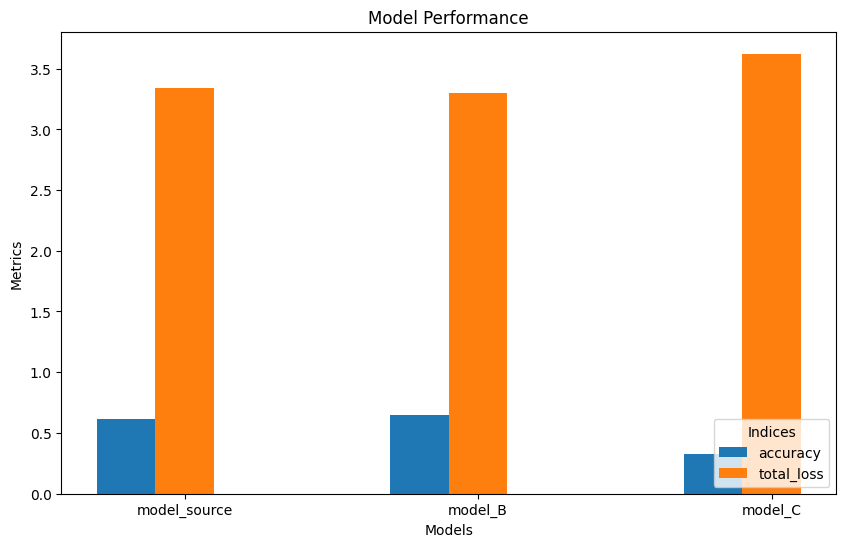

In [19]:
%matplotlib inline


plt.figure(figsize=(10, 6))



bar_width = 0.2
bar_positions = np.arange(len(results_df.columns))


for i, index in enumerate(results_df.index):
    plt.bar(
        bar_positions + i * bar_width,
        results_df.loc[index],
        width=bar_width,
        label=index
    )

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Performance')
plt.xticks(bar_positions + bar_width, results_df.columns)
plt.legend(title='Indices', loc='lower right')

plt.show()
